__Masking and Positions__

Now that we've learnt all the tools that we need to model strong lenses, I'm going to quickly cover how you should choose your mask and show you another neat trick to improve the speed and accuracy of your non-linear search. We'll skip running non-linear searches this tutorial - you've spent long enough waiting for non-linear searches to run (of course, you can run them yourself if you're really keen)!

In [ ]:
%matplotlib inline

from autofit import conf
from autofit.optimize import non_linear as nl
from autolens.data import ccd
from autolens.data.array import mask as msk
from autolens.model.profiles import light_profiles as lp
from autolens.model.profiles import mass_profiles as mp
from autolens.model.galaxy import galaxy as g
from autolens.model.galaxy import galaxy_model as gm
from autolens.pipeline import phase as ph
from autolens.data.plotters import ccd_plotters

In [59]:
# If you are using Docker, the paths to the chapter is as follows (e.g. comment out this line)!
# path = '/home/user/workspace/howtolens/chapter_2_lens_modeling'

# If you arn't using docker, you need to change the path below to the chapter 2 directory and uncomment it
# path = '/path/to/user/workspace/howtolens/chapter_2_lens_modeling'
conf.instance = conf.Config(config_path=path+'/configs/5_linking_phases', output_path=path+"/output")

Lets simulate the simple image we've used throughout this chapter again.

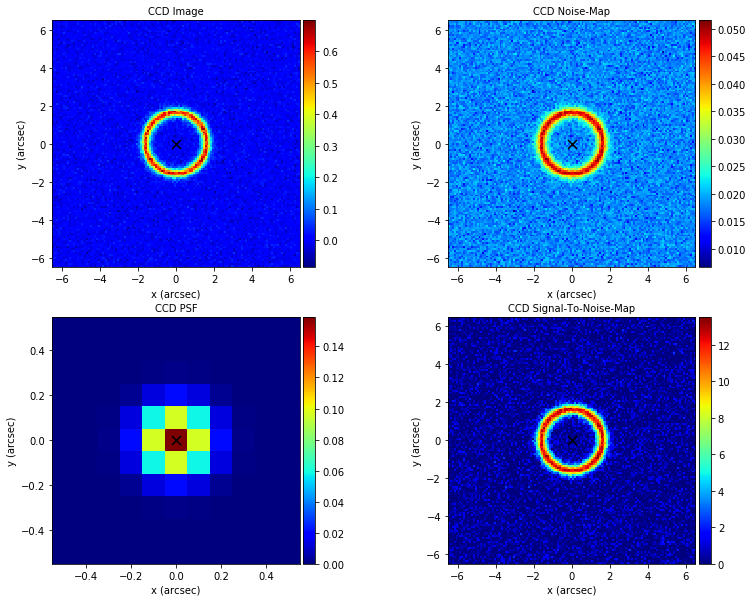

In [60]:
def simulate():

    from autolens.data.array import grids
    from autolens.model.galaxy import galaxy as g
    from autolens.lens import ray_tracing

    psf = ccd.PSF.simulate_as_gaussian(shape=(11, 11), sigma=0.1, pixel_scale=0.1)

    image_plane_grid_stack = grids.GridStack.grid_stack_for_simulation(shape=(130, 130), pixel_scale=0.1, psf_shape=(11, 11))

    lens_galaxy = g.Galaxy(mass=mp.SphericalIsothermal(centre=(0.0, 0.0), einstein_radius=1.6))
    source_galaxy = g.Galaxy(light=lp.SphericalExponential(centre=(0.0, 0.0), intensity=0.2, effective_radius=0.2))
    tracer = ray_tracing.TracerImageSourcePlanes(lens_galaxies=[lens_galaxy], source_galaxies=[source_galaxy],
                                                 image_plane_grid_stack=image_plane_grid_stack)

    image_simulated = ccd.CCDData.simulate(array=tracer.image_plane_image_for_simulation, pixel_scale=0.1,
                                           exposure_time=300.0, psf=psf, background_sky_level=0.1, add_noise=True)

    return image_simulated

ccd_data = simulate()
ccd_plotters.plot_ccd_subplot(ccd_data=ccd_data)

When it comes to determining an appropriate mask for this image, the best approach is to set up a mask using the mask module and pass it to a ccd plotter. You can then check visually if the mask is an appropriate size or not. Below, we choose an inner radius that cuts into our lensed source galaxy - clearly this isn't a good mask.

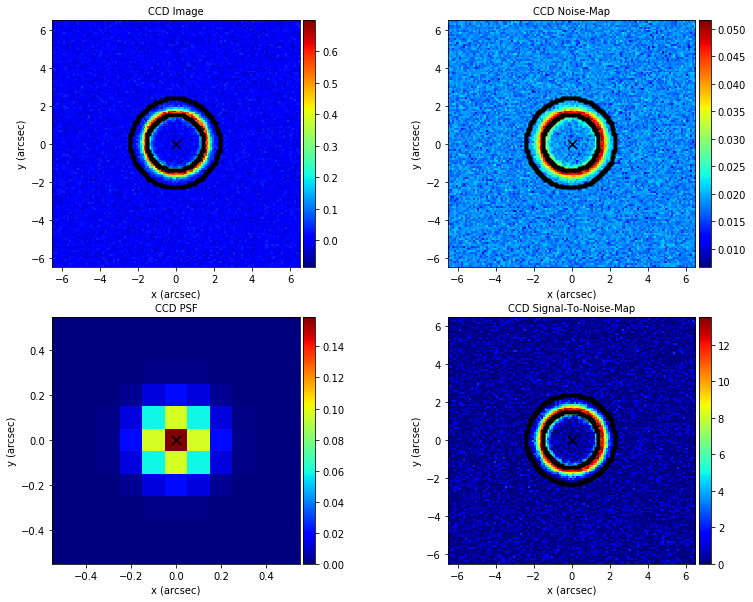

In [61]:
mask = msk.Mask.circular_annular(shape=ccd_data.shape, pixel_scale=ccd_data.pixel_scale, 
                                 inner_radius_arcsec=1.4, outer_radius_arcsec=2.4)
ccd_plotters.plot_ccd_subplot(ccd_data=ccd_data, mask=mask, extract_array_from_mask=True, zoom_around_mask=True)

So, lets decrease the inner radius to correct for this

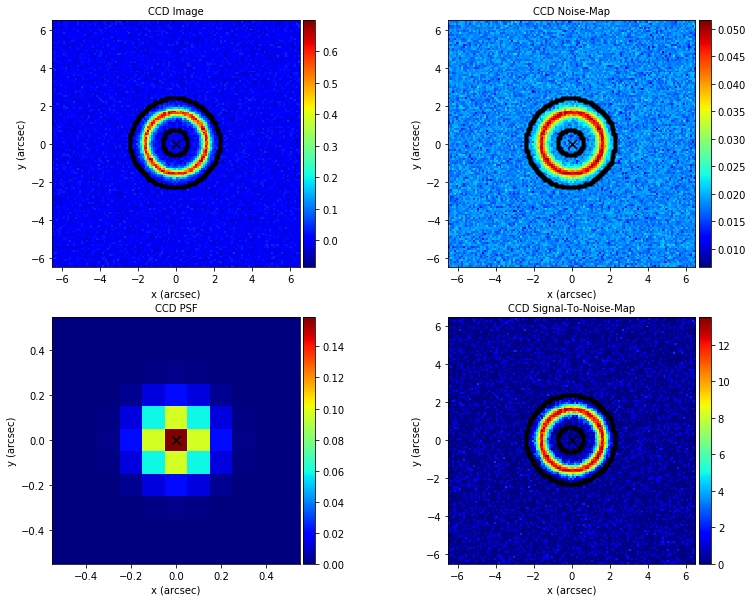

In [62]:
mask = msk.Mask.circular_annular(shape=ccd_data.shape, pixel_scale=ccd_data.pixel_scale, 
                                 inner_radius_arcsec=0.6, outer_radius_arcsec=2.4)
ccd_plotters.plot_ccd_subplot(ccd_data=ccd_data, mask=mask, extract_array_from_mask=True, zoom_around_mask=True)

When we run the phase, we don't pass it the mask as an array. Instead, we pass it the mask as a function. The reason for this will become clear in the next chapter, but for now I would say you just accept this syntax.

In [63]:
def mask_function():
    return msk.Mask.circular_annular(shape=ccd_data.shape, pixel_scale=ccd_data.pixel_scale, 
                                     inner_radius_arcsec=0.6, outer_radius_arcsec=2.4)

phase_with_custom_mask = ph.LensSourcePlanePhase(lens_galaxies=dict(lens=gm.GalaxyModel()),
                                source_galaxies=dict(source=gm.GalaxyModel()),
                                mask_function=mask_function, # <- We input the mask function here
                                optimizer_class=nl.MultiNest, phase_name='phase')

So, our mask encompasses the lensed source galaxy. However, is this really the right sized mask? Do we actually want a bigger mask? a smaller mask?

When it comes to masking, we are essentially balancing run-speed and accuracy. If speed wasn't a consideration, bigger masks would *always* be better, for two reasons:

1) The lensed source galaxy may have very faint emission that when you look at the plot above you don't notice. Overly aggressive masking risks you masking out some of that light - data which would better constrain your lens model!

2) When you fit an image with a model image, the fit is performed only within the masked region. Outside of the masked region it is possible that the model image produces some source-galaxy light in a region of the image where it isn't actually observed. If this region is masked, the poor fit in this region won't reduce the model's likelihood.

As you use PyAutoLens more, you will get a feel for how fast an analysis will run given a certain image resolution, lens model complexity, non-linear search priors / settings, etc. As you develop this intuition, I would recommend you always aim to use masks as big as possible, but still gives what you feel is a reasonable run-speed. Aggresive masking will get your code running fast - but it could lead you to infer an incorrect lens model!

If you are fitting the foreground lens galaxy's light, you pretty much have no choice but to use a large circular mask that will probably encompass the entire source-galaxy anyway.

We can also manually specify a set of image-pixels which correspond to the multiple images of the source-galaxy(s). During the analysis, PyAutoLens will first check that these pixels trace within a specified arc-second threshold of one another (which is controlled by the 'position_threshold' parameter of the 'general.ini' config file). This provides two benefits:

1) The analysis runs faster, as the non-linear search avoids searching regions of parameter space where the mass-model is clearly not accurate.

2) By removing these solutions, a global-maximum solution may be reached instead of a local-maxima. This is because removing the incorrect mass models makes the non-linear parameter space less complex.

We can easily check the image-positions are accurate by plotting them using our imaging_plotter (they are the magenta dots on the image).

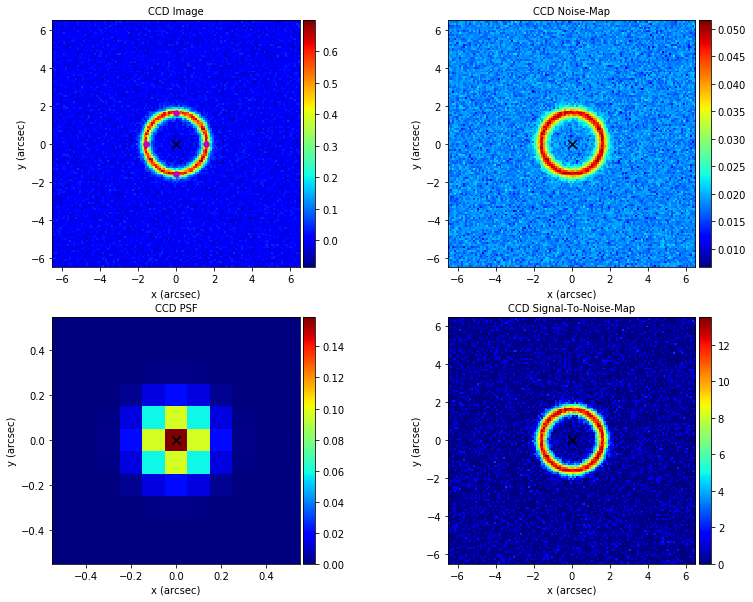

In [66]:
ccd_plotters.plot_ccd_subplot(ccd_data=ccd_data, positions=[[[1.6, 0.0], [0.0, 1.6], [-1.6, 0.0], [0.0, -1.6]]])

We can then tell our phase to use these positions in the analysis.

In [67]:
phase_with_positions = ph.LensSourcePlanePhase(lens_galaxies=dict(lens=gm.GalaxyModel()),
                                source_galaxies=dict(source=gm.GalaxyModel()),
                                use_positions=True, # <- We use the positionos here
                                optimizer_class=nl.MultiNest, phase_name='phase')

The positions are passed to the phase when we run it, which is shown below by commented out.

In [ ]:
# phase_with_positions.run(data=ccd_data, positions=[[[1.6, 0.0], [0.0, 1.6], [-1.6, 0.0], [0.0, -1.6]]])

You may observe multiple source-galaxies each with their own set of multiple-images. If you have a means by which to pair different positions to the same source galaxies (for example, spectroscopic data), you can set up multiple sets of positions, which each have to trace to within the position threshold of one another for the lens model to be accepted.

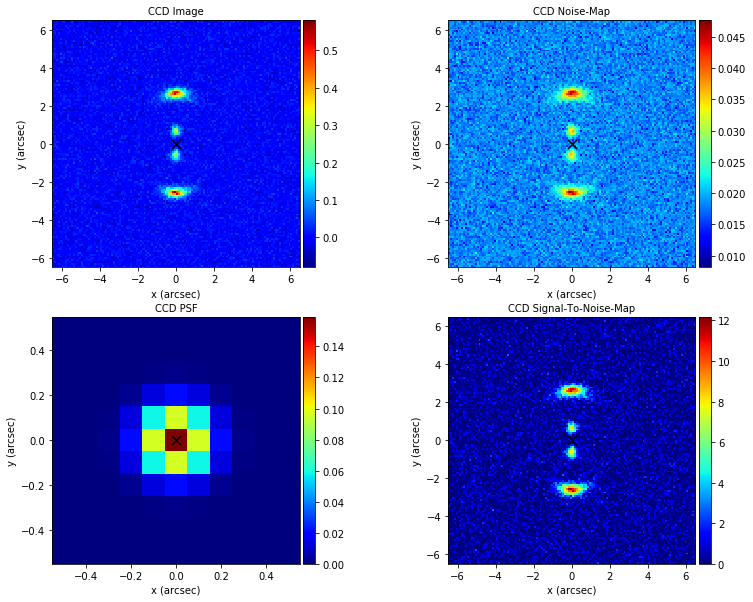

In [68]:
def simulate_two_source_galaxies():

    from autolens.data.array import grids
    from autolens.model.galaxy import galaxy as g
    from autolens.lens import ray_tracing

    psf = ccd.PSF.simulate_as_gaussian(shape=(11, 11), sigma=0.1, pixel_scale=0.1)

    image_plane_grid_stack = grids.GridStack.grid_stack_for_simulation(shape=(130, 130), pixel_scale=0.1, psf_shape=(11, 11))

    lens_galaxy = g.Galaxy(mass=mp.SphericalIsothermal(centre=(0.0, 0.0), einstein_radius=1.6))
    source_galaxy_0 = g.Galaxy(light=lp.SphericalExponential(centre=(1.0, 0.0), intensity=0.2, effective_radius=0.2))
    source_galaxy_1 = g.Galaxy(light=lp.SphericalExponential(centre=(-1.0, 0.0), intensity=0.2, effective_radius=0.2))
    tracer = ray_tracing.TracerImageSourcePlanes(lens_galaxies=[lens_galaxy], source_galaxies=[source_galaxy_0,
                                                                                               source_galaxy_1],
                                                 image_plane_grid_stack=image_plane_grid_stack)

    ccd_simulated = ccd.CCDData.simulate(array=tracer.image_plane_image_for_simulation, pixel_scale=0.1,
                                         exposure_time=300.0, psf=psf, background_sky_level=0.1, add_noise=True)

    return ccd_simulated

ccd_data = simulate_two_source_galaxies()
ccd_plotters.plot_ccd_subplot(ccd_data=ccd_data)

To specify the positions, we break the positions list into two cells. They will be plotted in different colours to represent the fact they trace from different source galaxies.

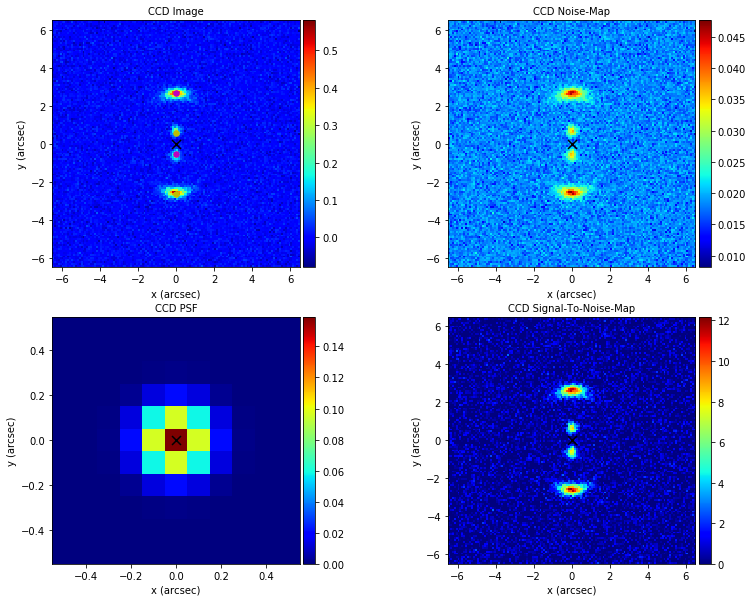

In [69]:
ccd_plotters.plot_ccd_subplot(ccd_data=ccd_data, positions=[[[2.65, 0.0], [-0.55, 0.0]], [[-2.65, 0.0], [0.55, 0.0]]])

Again, we tell our phase to use the positions and pass this list of pixels to our phase when we run it.

In [70]:
phase_with_x2_positions = ph.LensSourcePlanePhase(lens_galaxies=dict(lens=gm.GalaxyModel()),
                                source_galaxies=dict(source=gm.GalaxyModel()),
                                use_positions=True, # <- We use the positionos here
                                optimizer_class=nl.MultiNest, phase_name='phase')

# phase_with_x2_positions.run(data=ccd_data, positions=[[[2.65, 0.0], [-0.55, 0.0]], [[-2.65, 0.0], [0.55, 0.0]]])

At this point, I recommend that you checkout the 'workspace/tools/mask_maker.py' and 'workspace/tools/positions_maker.py' scripts. These tools allow you create custom masks and positions for a specific strong lens and output them to .fits / .dat files such that they can be loaded before an analysis.

When we cover pipelines next, you'll see that pipelines allow one to use a custom mask and set of positions for each lens for one generalized pipeline. Meaning that although we have to draw the masks and positions for each lens in a sample, once we've done that it won't impact the generality of our lens modeling pipelines!

Tutorial complete! There are two things you should bare in mind in terms of masking and positions:

1) Customizing the mask and positions for the analysis of one strong lens gets the analysis running fast and can provide accurate non-linear sampling. However, for a large sample of lenses, customizing the mask and positions will begin to take a lot of time. If you're willing to put that time and effort in, great, but these solutions __do not__ scale-up to large samples of lenses.

2) A word of warning - be *extremely* careful when using positions, especially if it is unclear if the lensed source galaxy has one or multiple source's of light. If your position threshold is small and the positions you give the analysis correspond to different parts of the source, you may remove the *correct lens model*. In my experience, as long as you keep the threshold above ~0.5" you'll be fine.

And with that, we've completed the chapter.